# Visualisations Plotly

#### Liens utiles :
- Site : https://plotly.com/python/
- figure reference : https://plotly.com/python/reference/index/
- API : https://plotly.com/python-api-reference/index.html
- px : https://plotly.com/python-api-reference/plotly.express.html

### Plusieurs "niveaux" dans Plotly :
Des submlodules :
- plotly.express
- plotly.graph_objects
- plotly.subplots
- plotly.figure_factory
- plotly.io

## Préparation

In [45]:
import pandas as pd
import plotly.express as px

In [46]:
# Charger les données
df_base = pd.read_csv("../../data/CSS_openalex.csv", low_memory=False)

In [47]:
# Ne selectionner que ceux qui ont CSS dans title ou abstract (|)
df = df_base[
    df_base["title"].str.contains("computational social science", case=False, na=False)
    | df_base["abstract"].str.contains(
        "computational social science", case=False, na=False
    )
].copy()

# passe la date en datetime
df["publication_date"] = pd.to_datetime(df["publication_date"])

In [48]:
df.shape

(1007, 183)

## Refaire la figure d'emilien

## Passer à l'oral pour le timmng ?

In [49]:
# import plotly.express as px

# table = (
#     df[df["publication_year"] >= 2000]["publication_year"].value_counts().reset_index()
# )

# fig = px.scatter(
#     table,
#     x="publication_year",
#     y="count",
#     trendline="ols",
#     title="Évolution temporelle avec droite de régression",
#     labels={"publication_year": "Date", "count": "Valeur"},
# )

# # fig.update_traces(marker=dict(opacity=0.5))
# fig.show()


## Améliorer la figure de la première séance

La figure de base :

In [50]:
# regrouper par année et compter le nombre de publi
fig = px.bar(df.resample("YS", on="publication_date").size())

# Afficher le graphique
fig.show()

/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [51]:
# soit on ajoute directement des éléments lors de la création :

fig_test = px.bar(
    df.resample("YS", on="publication_date").size(),
    labels={"value": "Nombre de publications", "publication_date": "Date"},
    title="Mon super titre",
)

# Afficher le graphique
fig_test.show()

/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [52]:
# Ou alors on peut faire un .update_layout() après la création du graphique :

# Repartir de notre première figure
fig = px.bar(df.resample("YS", on="publication_date").size())

# Et tenter d'améliorer le graphique
# modifier le layout
fig.update_layout(
    title="Évolution temporelle du nombre de publications",  # ajouter un titre
    xaxis_title="Date",  # Renomer l'axe y en Date
    yaxis_title="Nombre de publications",  # renommer les y
    template="plotly_white",  # changer le style du graphique
    showlegend=False,  # masquer la légende
)

# Modifier les traces
# fig.update_traces(marker_color="#1f77b4")

# Afficher le graphique
fig.show()

/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Je passe, mais encore une fois, plein de façons de faire la même chose

In [53]:
# # Préparer les données pour px.bar avec x= et y=
# df_yearly = df.resample("YS", on="publication_date").size().reset_index(name="count")

# fig = px.bar(
#     df_yearly,
#     x="publication_date",
#     y="count",
#     labels={"count": "Nombre de publications", "publication_date": "Date"},
#     title="Évolution temporelle du nombre de publications",
# )

# fig.update_layout(
#     template="plotly_white",
#     # showlegend=False,
# )
# fig.show()


## Distinguer par top journal

Retravailler les données pour avoir un dataframe du nb de publi par journal dans le temps

(NB : j'aurai plutôt du parler de source plutôt que de journal)

In [54]:
# Calculer le top 5 des journaux par nombre de publications
top_journals = df["primary_location.source.display_name"].value_counts().head(5).index

# Filtrer le DataFrame pour ne garder que les publications dans ces journaux
df_top_journals = df[df["primary_location.source.display_name"].isin(top_journals)]

# Grouper par année et journal
pubs_by_journal_year = (
    df_top_journals.groupby(
        [
            df_top_journals["publication_date"].dt.year,
            "primary_location.source.display_name",
        ]
    )
    .size()
    .reset_index(name="count")
    .rename(columns={"publication_date": "year"})
)

In [55]:
# type(pubs_by_journal_year)
# pubs_by_journal_year

In [56]:
# Faire la figure
fig_journals = px.line(
    pubs_by_journal_year,
    x="year",
    y="count",
    color="primary_location.source.display_name",
    markers=True,
    labels={
        "year": "Année",
        "count": "Nombre de publications",
        "primary_location.source.display_name": "Journal",
    },
    title="Évolution du nombre de publications par journal (Top 5)",
)

fig_journals.show()

/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### faire simplement des miniplots / facet_col

In [57]:
pubs_by_journal_year["couleur"] = pubs_by_journal_year[
    "primary_location.source.display_name"
].map(color_map)

fig_journals = px.line(
    pubs_by_journal_year,
    x="year",
    y="count",
    facet_col="primary_location.source.display_name",
    markers=True,
    labels={
        "year": "Année",
        "count": "Nombre de publications",
        "primary_location.source.display_name": "Journal",
    },
    title="Évolution du nombre de publications par journal (Top 5)",
)
fig_journals.show()


/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [58]:
# color_discrete_sequence=["#91d0d5"],
# color_discrete_sequence=px.colors.qualitative.Pastel
# color_discrete_sequence=["#f4ac57", "#624f8f", "#44a77d"]

### Faire des trucs "intelligents" en se faisant assister par un LLM quand on code comme une brouette :

On peut faire des trucs chouettes.
Le risque c'est :
- de ne pas comprendre ce qu'on fait
- de faire nawak
- de ne pas progresser
- pour que ça marche ça demande souvent en fait de savoir ce qu'on veut faire et savoir déjà plus ou moins le faire



In [59]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Calculer le top 5 des journaux par nombre de publications
top_journals = df["primary_location.source.display_name"].value_counts().head(5).index

# Créer des miniplots
journals = list(top_journals)
cols = 3
rows = 2

fig_miniplots = make_subplots(rows=rows, cols=cols, subplot_titles=journals)

# les remplir
for idx, journal in enumerate(journals):
    row = idx // cols + 1  # official dark magic
    col = idx % cols + 1  # official dark magic
    for j in journals:
        data = pubs_by_journal_year[
            pubs_by_journal_year["primary_location.source.display_name"] == j
        ]
        color = None if j == journal else "lightgray"
        showlegend = False
        fig_miniplots.add_trace(
            go.Scatter(
                x=data["year"],
                y=data["count"],
                mode="lines+markers",
                name=j,
                line=dict(color=color),
                marker=dict(color=color),
                showlegend=showlegend,
                opacity=1.0 if j == journal else 0.5,
            ),
            row=row,
            col=col,
        )

fig_miniplots.update_layout(
    height=300 * rows,
    width=350 * cols,
    title_text="Mini-plots par journal",
    template="plotly_white",
)
fig_miniplots.show()


> idx // cols : donne le numéro de ligne, en partant de 0.
(division entière — combien de fois cols rentre dans idx)

> idx % cols : donne le numéro de colonne, en partant de 0.
(modulo — reste de la division, pour avancer dans la ligne)

> +1 : les lignes et colonnes commencent à 1 et pas 0

## Enregistrer
(si jamais : possible de faire une sauvegarde vite fait en haut à droite de la figure)  
(barre d'outil, l'icone d'appareil photo le plus a gauche)

### En image fixe :
Normalement nécessaire d'installer kaleido si il ne l'est pas déjà.

In [60]:
## cf. la doc :
## The kaleido package has no dependencies and can be installed using pip...

# pip install -U kaleido

## or conda.

# conda install -c conda-forge python-kaleido


In [61]:
fig.write_image("fig1.png")

Souvent le résultat brut est un peu moche :  
ajouter quelques paramètrès permet d'améliorer le rendu.
- scale (qualité de l'image)
- width
- height

In [62]:
# fig.write_image("fig2.png",
#                 width=800,
#                 height=450,
#                 scale=4
#                )

### En html :

In [63]:
fig.write_html("file.html")

Bien souvent : 
- S'inspirer d'exemples en lignes.
- puis de la génération de code avec chatGPT / github copilot

## Directement dans pandas en "backend"

<Axes: xlabel='type'>

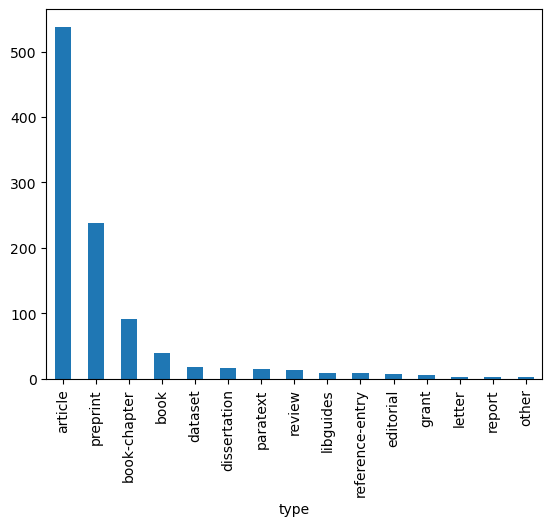

In [64]:
pd.options.plotting.backend = "matplotlib"  # = de base
df["type"].value_counts().plot(kind="bar")

In [65]:
pd.options.plotting.backend = "plotly"
df["type"].value_counts().plot(kind="bar")